# Food Detection Project

This notebook implements a food detection system using CNN models. The steps include:
1. Importing the data
2. Mapping images to classes
3. Creating annotations for training and testing
4. Displaying images with bounding boxes
5. Building and training CNN models for classification


In [25]:
# Import necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Step 1: Import the Data

First, we'll import the data and create two dataframes:
1. A dataframe mapping imageID to image data & food type
2. A dataframe mapping imageID to bounding box data from annotations


In [26]:
# Define paths
data_dir = 'data/Food_101'
annotations_dir = 'data/annotations'

# Get all food categories
food_categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Found {len(food_categories)} food categories: {food_categories}")


Found 17 food categories: ['ice_cream', 'samosa', 'donuts', 'waffles', 'falafel', 'ravioli', 'strawberry_shortcake', 'spring_rolls', 'hot_dog', 'apple_pie', 'chocolate_cake', 'tacos', 'pancakes', 'pizza', 'nachos', 'french_fries', 'onion_rings']


In [27]:
# Create a dataframe mapping imageID to image data & food type
image_data = []

for category in tqdm(food_categories, desc="Processing food categories"):
    category_dir = os.path.join(data_dir, category)
    image_files = glob.glob(os.path.join(category_dir, "*.jpg"))

    for img_path in image_files:
        img_filename = os.path.basename(img_path)
        img_id = os.path.splitext(img_filename)[0]  # Remove extension to get ID

        image_data.append({
            'image_id': img_id,
            'image_path': img_path,
            'food_type': category
        })

# Create the dataframe
image_df = pd.DataFrame(image_data)
print(f"Created image dataframe with {len(image_df)} entries")
image_df.head()


Processing food categories: 100%|██████████| 17/17 [00:00<00:00, 466.55it/s]

Created image dataframe with 16256 entries


image_id                           image_path  food_type
0  1795168  data/Food_101/ice_cream/1795168.jpg  ice_cream
1  3730391  data/Food_101/ice_cream/3730391.jpg  ice_cream
2  1052863  data/Food_101/ice_cream/1052863.jpg  ice_cream
3  2557070  data/Food_101/ice_cream/2557070.jpg  ice_cream
4  2217633  data/Food_101/ice_cream/2217633.jpg  ice_cream

In [28]:
# Function to parse XML annotation file
def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Get image ID from filename
    filename = root.find('filename').text
    image_id = os.path.splitext(filename)[0]

    # Get image dimensions
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Get all objects (bounding boxes)
    boxes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        boxes.append({
            'image_id': image_id,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'width': width,
            'height': height
        })

    return boxes


In [29]:
# Create a dataframe mapping imageID to bounding box data from annotations
annotation_data = []

# Get all annotation files
annotation_files = glob.glob(os.path.join(annotations_dir, "*.xml"))
print(f"Found {len(annotation_files)} annotation files")

# Parse each annotation file
for xml_path in tqdm(annotation_files, desc="Parsing annotation files"):
    boxes = parse_annotation(xml_path)
    annotation_data.extend(boxes)

# Create the dataframe
annotation_df = pd.DataFrame(annotation_data)
print(f"Created annotation dataframe with {len(annotation_df)} entries")
annotation_df.head()


Found 500 annotation files


Parsing annotation files: 100%|██████████| 500/500 [00:00<00:00, 7654.62it/s]

Created annotation dataframe with 553 entries


image_id         class  xmin  ymin  xmax  ymax  width  height
0   209662        nachos    65    80   430   289    512     382
1   172042  french_fries   102   164   512   389    512     512
2   248212        nachos    13    36   382   468    382     512
3   524839   onion_rings    71    11   427   463    512     512
4    74527   onion_rings   210    10   455   272    512     383

## Step 2: Map Training and Testing Images to Classes

Now we'll split the data into training and testing sets with a 70:30 ratio, ensuring that the same IDs are in corresponding train/test sets for both dataframes.


In [30]:
# Get unique image IDs that have annotations
annotated_image_ids = annotation_df['image_id'].unique()
print(f"Found {len(annotated_image_ids)} unique images with annotations")

# Get all unique image IDs
all_image_ids = image_df['image_id'].unique()
print(f"Found {len(all_image_ids)} total unique images")

# Create a mapping of image_id to food_type for stratified splitting
image_id_to_food_type = dict(zip(image_df['image_id'], image_df['food_type']))

# Create a DataFrame for annotated images with their food types for stratified splitting
annotated_df = pd.DataFrame({
    'image_id': annotated_image_ids,
    'food_type': [image_id_to_food_type[img_id] for img_id in annotated_image_ids]
})

# Split the annotated images into training and testing sets (70:30 ratio) with stratification by food type
train_annotated_df, test_annotated_df = train_test_split(
    annotated_df,
    test_size=0.3,
    random_state=42,
    stratify=annotated_df['food_type']  # Stratify by food type
)

# Extract the image IDs
train_annotated_ids = train_annotated_df['image_id'].values
test_annotated_ids = test_annotated_df['image_id'].values

print(f"Training set (annotated): {len(train_annotated_ids)} images")
print(f"Testing set (annotated): {len(test_annotated_ids)} images")

# Get non-annotated image IDs
non_annotated_ids = np.setdiff1d(all_image_ids, annotated_image_ids)
print(f"Non-annotated images: {len(non_annotated_ids)} images")

# Create a DataFrame for non-annotated images with their food types for stratified splitting
non_annotated_df = pd.DataFrame({
    'image_id': non_annotated_ids,
    'food_type': [image_id_to_food_type[img_id] for img_id in non_annotated_ids]
})

# Split non-annotated images into train and test with the same ratio, stratified by food type
train_non_annotated_df, test_non_annotated_df = train_test_split(
    non_annotated_df,
    test_size=0.3,
    random_state=42,
    stratify=non_annotated_df['food_type']  # Stratify by food type
)

# Extract the image IDs
train_non_annotated_ids = train_non_annotated_df['image_id'].values
test_non_annotated_ids = test_non_annotated_df['image_id'].values

# Combine annotated and non-annotated IDs for final train/test sets
train_ids = np.concatenate([train_annotated_ids, train_non_annotated_ids])
test_ids = np.concatenate([test_annotated_ids, test_non_annotated_ids])

print(f"Final training set: {len(train_ids)} images")
print(f"Final testing set: {len(test_ids)} images")


Found 500 unique images with annotations
Found 16256 total unique images
Training set (annotated): 350 images
Testing set (annotated): 150 images
Non-annotated images: 15756 images
Final training set: 11379 images
Final testing set: 4877 images


In [31]:
# Create training and testing dataframes for images (using all images)
train_image_df = image_df[image_df['image_id'].isin(train_ids)]
test_image_df = image_df[image_df['image_id'].isin(test_ids)]

# Create training and testing dataframes for annotations (only for annotated images)
train_annotation_df = annotation_df[annotation_df['image_id'].isin(train_annotated_ids)]
test_annotation_df = annotation_df[annotation_df['image_id'].isin(test_annotated_ids)]

print(f"Training image dataframe: {len(train_image_df)} entries")
print(f"Testing image dataframe: {len(test_image_df)} entries")
print(f"Training annotation dataframe: {len(train_annotation_df)} entries")
print(f"Testing annotation dataframe: {len(test_annotation_df)} entries")

# Verify that the stratification is working correctly
print("\nVerifying stratification by food category:")
train_food_counts = train_image_df['food_type'].value_counts(normalize=True)
test_food_counts = test_image_df['food_type'].value_counts(normalize=True)

# Display the distribution of food types in training and testing sets
print("\nTraining set food type distribution (%):")
print(train_food_counts * 100)
print("\nTesting set food type distribution (%):")
print(test_food_counts * 100)

# Calculate the difference in distribution
print("\nDifference in distribution (percentage points):")
food_types = set(train_food_counts.index) | set(test_food_counts.index)
for food_type in food_types:
    train_pct = train_food_counts.get(food_type, 0) * 100
    test_pct = test_food_counts.get(food_type, 0) * 100
    diff = abs(train_pct - test_pct)
    print(f"{food_type}: {diff:.2f}pp")


Training image dataframe: 11379 entries
Testing image dataframe: 4877 entries
Training annotation dataframe: 389 entries
Testing annotation dataframe: 164 entries

Verifying stratification by food category:

Training set food type distribution (%):
food_type
ice_cream               6.151683
samosa                  6.151683
french_fries            6.151683
nachos                  6.151683
pizza                   6.151683
pancakes                6.151683
tacos                   6.151683
chocolate_cake          6.151683
hot_dog                 6.151683
spring_rolls            6.151683
strawberry_shortcake    6.151683
ravioli                 6.151683
falafel                 6.151683
waffles                 6.151683
donuts                  6.151683
onion_rings             6.151683
apple_pie               1.573073
Name: proportion, dtype: float64

Testing set food type distribution (%):
food_type
ice_cream               6.151323
samosa                  6.151323
french_fries            6.1513

## Step 3: Create Annotations for Training and Testing Images

The annotations have already been created and loaded into our dataframes. Let's examine the distribution of classes in our annotations.


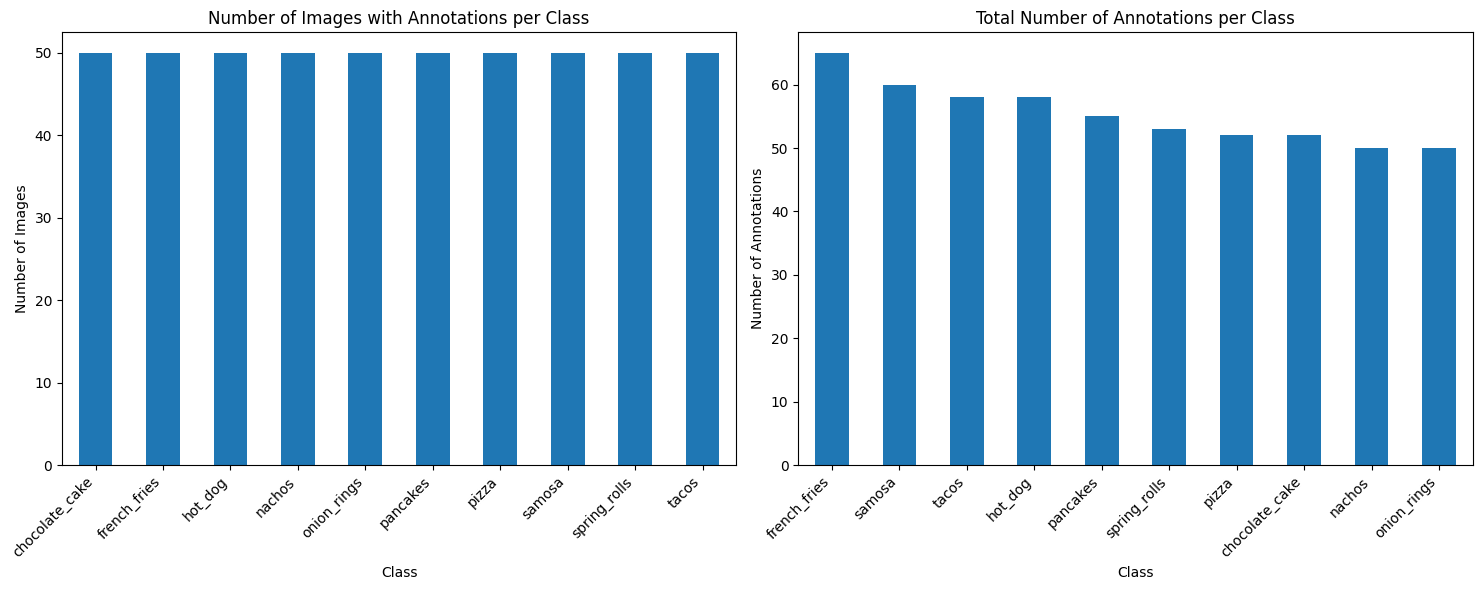

In [32]:
# Count the number of images with annotations per class
images_with_annotations = annotation_df.groupby('class')['image_id'].nunique()

# Count total number of annotations per class
annotations_per_class = annotation_df['class'].value_counts()

# Create subplots
plt.figure(figsize=(15, 6))

# Plot 1: Images with annotations per class
plt.subplot(1, 2, 1)
images_with_annotations.plot(kind='bar')
plt.title('Number of Images with Annotations per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

# Plot 2: Total annotations per class  
plt.subplot(1, 2, 2)
annotations_per_class.plot(kind='bar')
plt.title('Total Number of Annotations per Class')
plt.xlabel('Class')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Step 4: Display Images with Bounding Boxes

Now let's display some images with their bounding boxes to verify our data.


In [33]:
# Function to display an image with its bounding boxes
def display_image_with_boxes(image_id, image_df, annotation_df):
    # Get image path
    image_row = image_df[image_df['image_id'] == image_id].iloc[0]
    image_path = image_row['image_path']
    food_type = image_row['food_type']

    # Get annotations for this image
    boxes = annotation_df[annotation_df['image_id'] == image_id]

    # Load and display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    plt.figure(figsize=(10, 8))
    plt.imshow(img)

    # Draw bounding boxes
    for _, box in boxes.iterrows():
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        class_name = box['class']

        # Create rectangle
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                            fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Add label
        plt.text(xmin, ymin - 5, class_name, 
                 bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')

    plt.title(f"Image ID: {image_id}, Food Type: {food_type}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Images with annotations:


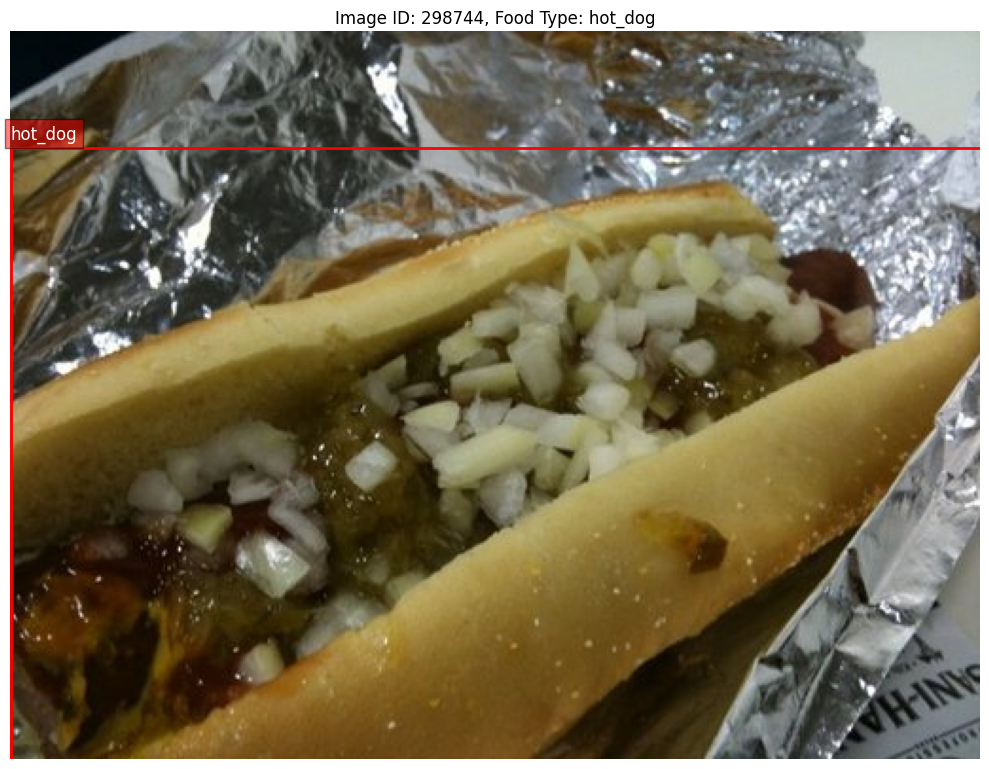

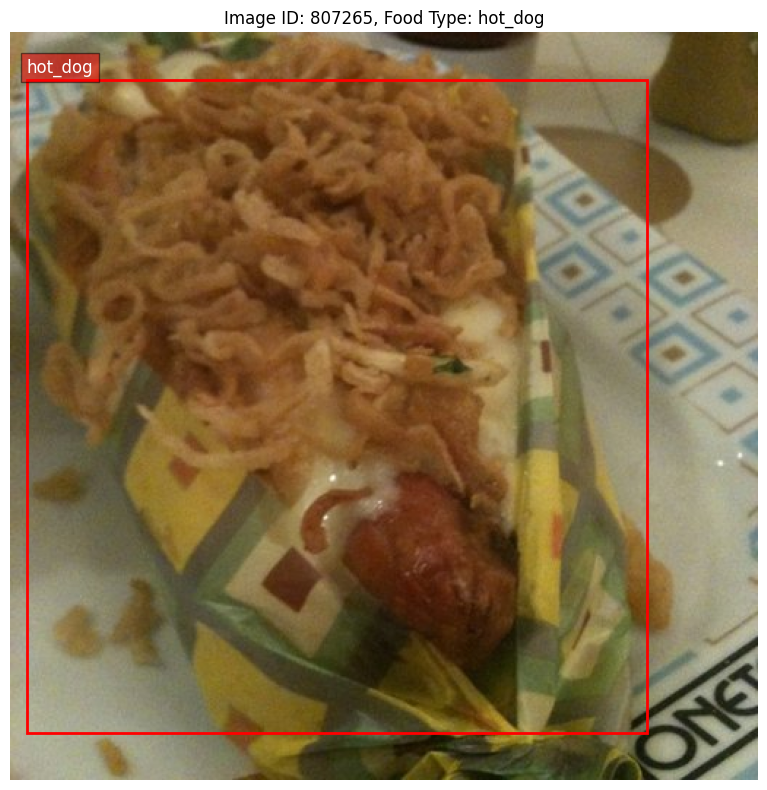

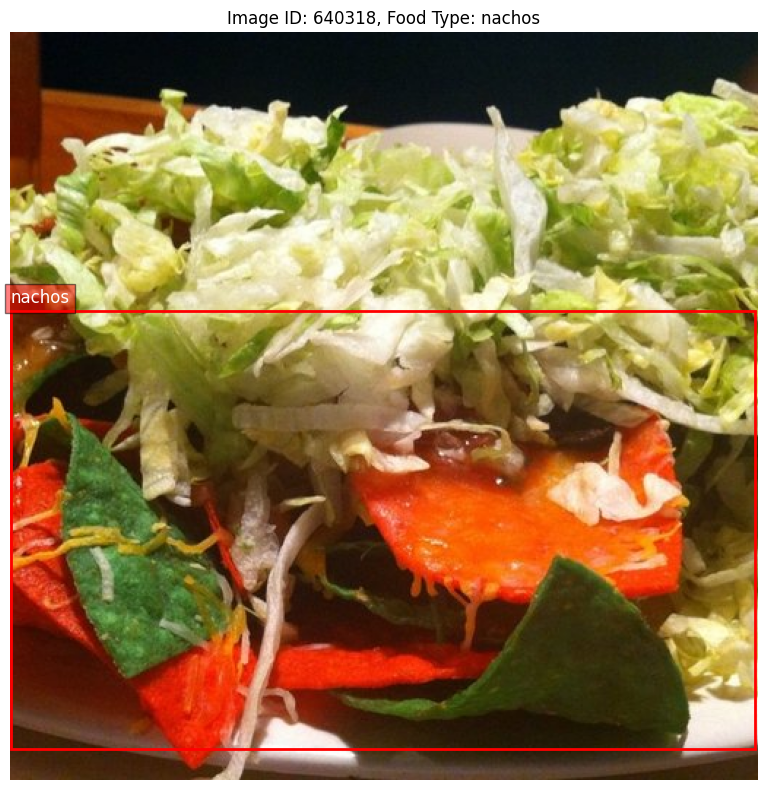

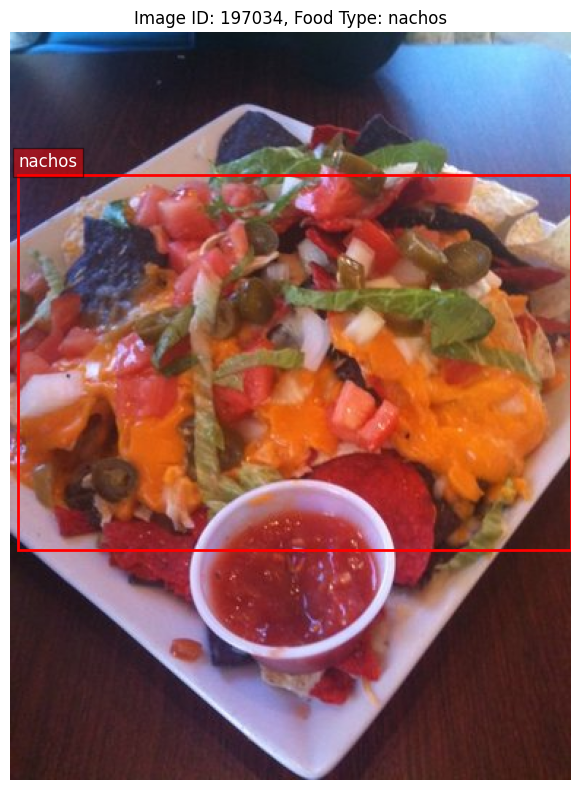


Images without annotations:


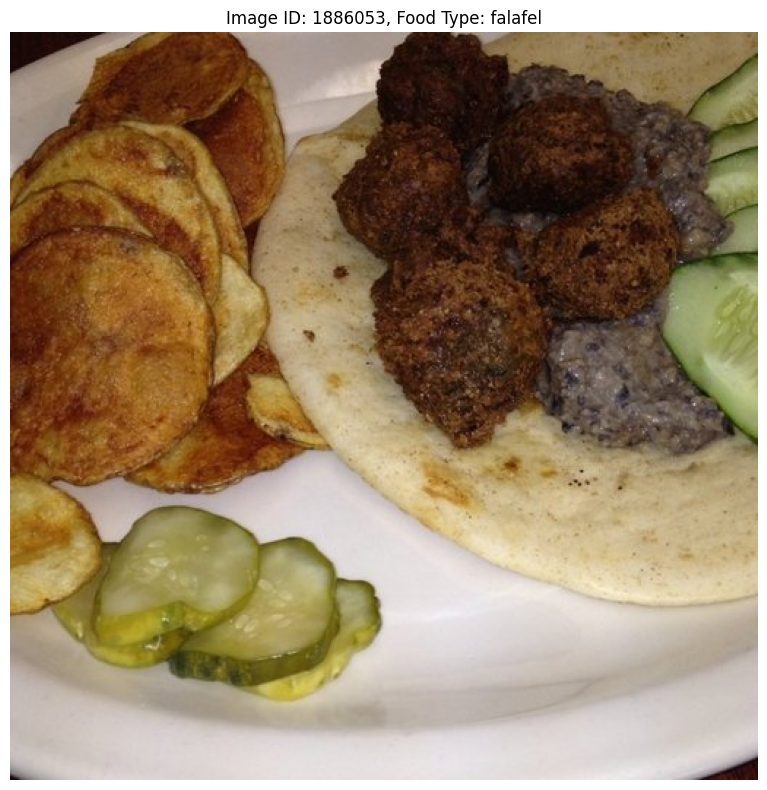

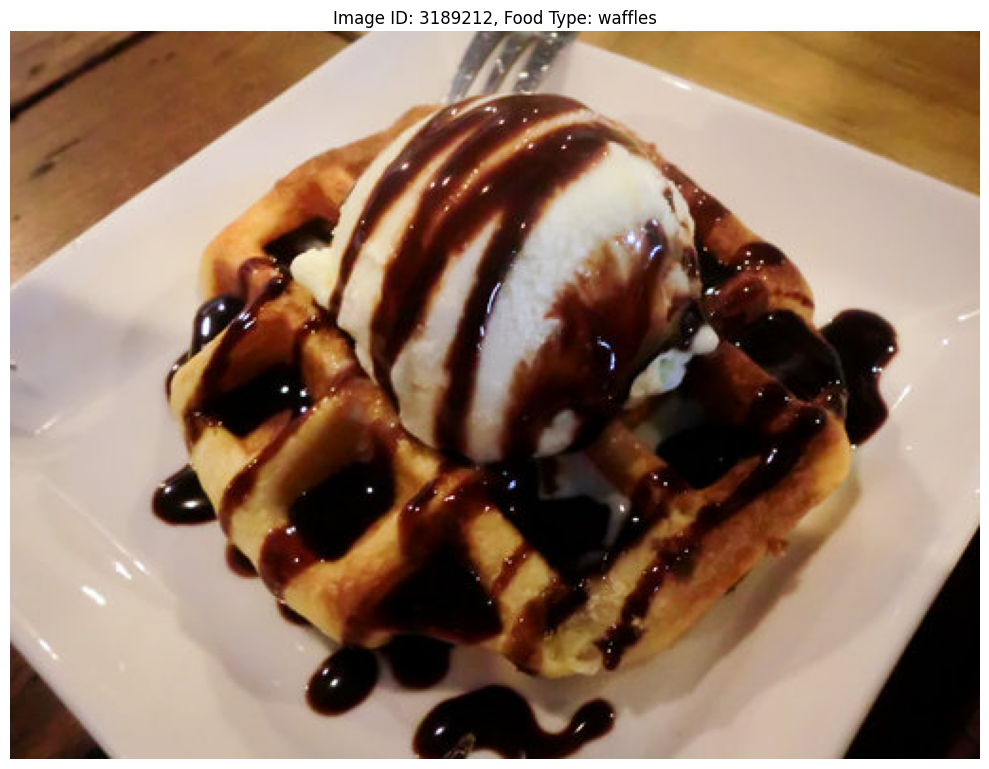

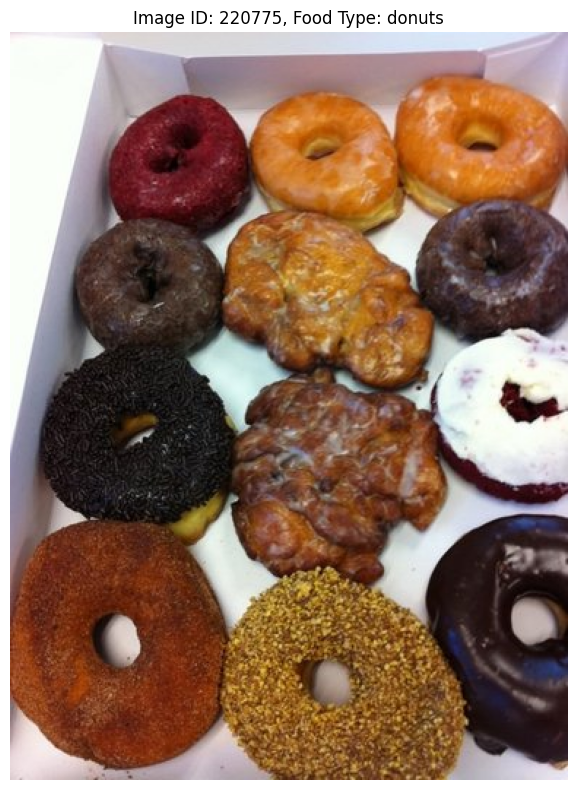

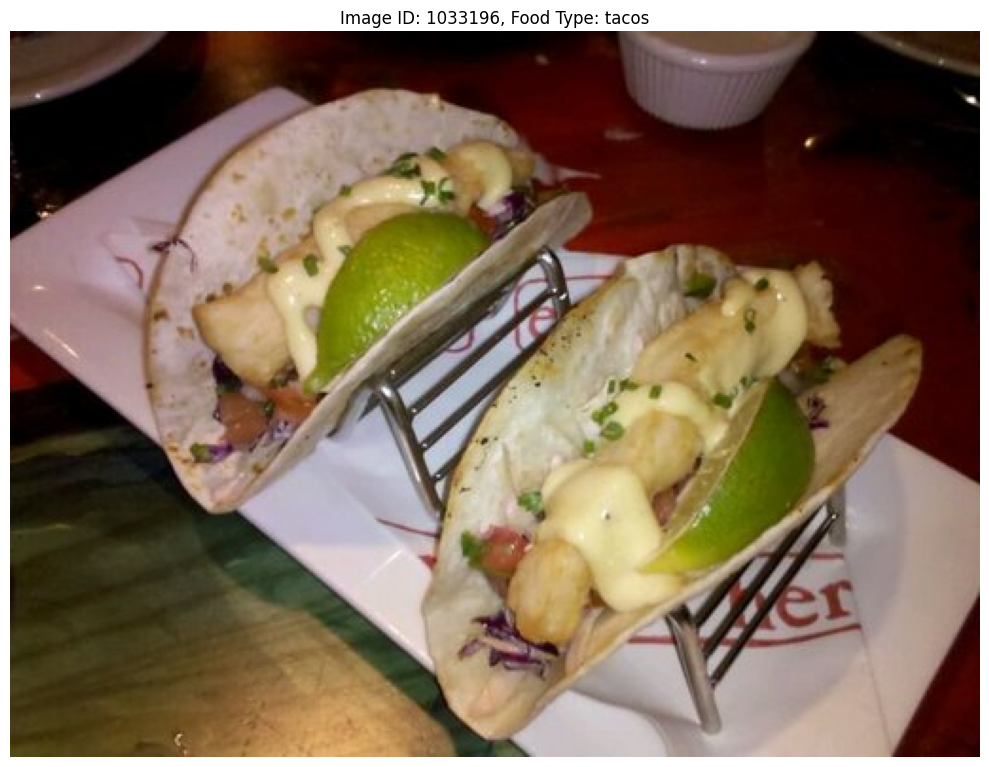

In [35]:
# Get a mix of annotated and non-annotated image IDs
annotated_sample = np.random.choice(annotated_image_ids, size=4, replace=False)
non_annotated_sample = np.random.choice(non_annotated_ids, size=4, replace=False)

# Display annotated images
print("Images with annotations:")
for img_id in annotated_sample:
    display_image_with_boxes(img_id, image_df, annotation_df)

# Display non-annotated images
print("\nImages without annotations:")
for img_id in non_annotated_sample:
    display_image_with_boxes(img_id, image_df, annotation_df)


In [36]:
train_image_df.head()

image_id                           image_path  food_type
1  3730391  data/Food_101/ice_cream/3730391.jpg  ice_cream
2  1052863  data/Food_101/ice_cream/1052863.jpg  ice_cream
3  2557070  data/Food_101/ice_cream/2557070.jpg  ice_cream
4  2217633  data/Food_101/ice_cream/2217633.jpg  ice_cream
6   258424   data/Food_101/ice_cream/258424.jpg  ice_cream

In [37]:
test_image_df.head()

image_id                           image_path  food_type
0   1795168  data/Food_101/ice_cream/1795168.jpg  ice_cream
5   2494775  data/Food_101/ice_cream/2494775.jpg  ice_cream
8   3009207  data/Food_101/ice_cream/3009207.jpg  ice_cream
17  1223415  data/Food_101/ice_cream/1223415.jpg  ice_cream
21    85514    data/Food_101/ice_cream/85514.jpg  ice_cream